In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, recall_score, precision_score, roc_auc_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_predict

In [2]:
# Sets the Ipython options

InteractiveShell.ast_node_interactivity = "all"

<h6>Design

In [3]:
# Sizes

title_size = 50
tick_size = 30
text_size = 30

<h6>Set up

In [4]:
df = pd.read_csv(r'/mnt/d/Kaggle/Telecom_Churn_Prediction/Cleaned/df_cleaned')

random_seed = 34

Stratification

In [5]:
stratified_shuffle_split = StratifiedShuffleSplit(test_size=0.2, random_state=random_seed)

In [6]:
for train_index, test_index in stratified_shuffle_split\
                                    .split(df.drop(['Churn'], axis = 1), 
                                           df['Churn']):
    
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

Counter(df['Churn'])
Counter(strat_train_set['Churn'])
Counter(strat_test_set['Churn'])

Counter({'No': 5174, 'Yes': 1869})

Counter({'No': 4139, 'Yes': 1495})

Counter({'No': 1035, 'Yes': 374})

Train Test Sets

In [7]:
X_train = strat_train_set.drop(['customerID','Churn'], axis = 1)
X_test = strat_test_set.drop(['customerID','Churn'], axis = 1)

In [8]:
y_train = strat_train_set['Churn'].apply(lambda x : 0 if x == 'No' else 1)
y_test = strat_test_set['Churn'].apply(lambda x : 0 if x == 'No' else 1)

<h6>Pipelines

In [9]:
# One Hot Encoder

categorical_pipeline = Pipeline([
    ('One_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False))
])

# Column Transformer

column_transformer = \
    ColumnTransformer([
        ('Categorical_pipeline', categorical_pipeline, 
                                      make_column_selector(dtype_include=['O']))], 
    remainder='passthrough')

Functions

In [10]:
# Computational
   
def find_optimal_threshold(y_ground_truth, y_predicted):
    
    fpr, tpr, thresholds = roc_curve(y_ground_truth, y_predicted[:,1])
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold

def return_recall_precision_f1(y_ground_truth, y_predicted, threshold, refit_time, model_name='model'):
    
    recall = recall_score(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))
    precision = precision_score(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))
    f1 = f1_score(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))
    
    # https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077

    roc_auc = roc_auc_score(y_train, y_predicted[:,1])
     
    metrics_df = pd.DataFrame(columns = ['recall', 'precision', 'f1-score', 'roc-auc', 'fit-time'], 
                              data = [[recall, precision, f1, roc_auc, refit_time]], 
                              index = ['{}'.format(model_name)])
    
    
    return metrics_df

In [11]:
# Plots

def plot_confusion_matrix(y_ground_truth, y_predicted, threshold):

    fig, ax = plt.subplots(figsize=(5,5))

    computed_confusion_matrix = \
            confusion_matrix(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))


    sns.heatmap(pd.DataFrame(computed_confusion_matrix), 
                annot=True, 
                fmt=".0f", 
                square=True,
                ax = ax,
                cbar=False,
                annot_kws={"size": text_size}
    )

    ax.set_ylabel('Actual Class', fontsize=text_size)
    ax.set_xlabel('Predicted Class', fontsize=text_size)
    ax.tick_params(labelsize=tick_size)
    ax.set_title('Thr={:.2f}'.format(threshold), fontsize=title_size-10)
    plt.show();

def plot_compare_score(score, 
                       colors=['black', 
                               'white', 
                               sns.color_palette("rocket").as_hex()[0], 
                               sns.color_palette("rocket").as_hex()[-1]]):
    
    ## Colors

    meta_color = colors[0]
    meta_color_r = colors[1]
    ax_color = colors[2]
    ax2_color = colors[3]

    ## Plots

    # Scores

    fig, ax = plt.subplots(figsize=(20,10))

    sns.barplot(data=results_df, 
            x=results_df.index,
            y=score,
            palette = [ax_color],
            ax = ax)


    # Fit time

    ax2 = plt.twinx()

    sns.lineplot(x=results_df.index, 
                 y='fit-time', 
                 data=results_df, 
                 marker='o', 
                 color=ax2_color, 
                 lw=3, 
                 ax=ax2)
        
    ## Design
        
    # ax

    ax.set_ylim((0,1))

    ax.set_ylabel('{}'.format(score), fontsize=text_size, color=ax_color)
    ax.set_xlabel('Modèles', fontsize=text_size, color=meta_color)

    ax.tick_params(labelsize=tick_size)
    ax.tick_params(colors=ax_color, axis='y')
    ax.tick_params(colors=meta_color, axis='x')

    ax.spines['bottom'].set_color(meta_color)
    ax.spines['top'].set_color(meta_color) 
    ax.spines['right'].set_color(ax2_color)
    ax.spines['left'].set_color(ax_color)

    ax.spines['left'].set_lw(3)
    ax.spines['right'].set_lw(3)

    for bars in ax.containers:
            ax.bar_label(bars, fmt='%.2f', fontsize=text_size, color=meta_color)

    # ax2


    ax2.set_ylabel('Fit Time', fontsize=text_size, color=ax2_color)

    ax2.tick_params(labelsize=tick_size, colors=ax2_color)

    ax2.spines['bottom'].set_color(meta_color_r)
    ax2.spines['top'].set_color(meta_color_r) 
    ax2.spines['right'].set_color(ax2_color)
    ax2.spines['left'].set_color(ax_color)


    # plt

    plt.title('{} (Test set ; CV:5)'.format(score),
              fontsize=title_size,
              pad=20, color=meta_color) 

    plt.show();

<center><h3>Modeling

Scoring

In [12]:
scoring = {'roc_auc': 'roc_auc'}

model_refit = 'roc_auc'

LR

In [13]:
lr_pipe = Pipeline([
    ('Column_transformer', column_transformer),
    ('Over_Sampling', None),
    ('Under_Sampling', None),
    ('Scaler', None),
    ('Dim_Reduction', None),
    ('Logistic_regression', LogisticRegression(random_state=random_seed))
])

In [14]:
lr_pipe_params = [{
    
    # Sampling Params
    
    'Over_Sampling': [None, SMOTE(random_state=random_seed), ADASYN(random_state=34)],
    'Under_Sampling': [None, RandomUnderSampler(random_state=34)],
    
    # Scaling Params
    
    'Scaler' : [None, StandardScaler(), MinMaxScaler(), RobustScaler()], 
    
    # Dimentionality Reduction
    
    #'Dim_Reduction' : [PCA(n_components=2), PCA(n_components=5), PCA(n_components=10)],
    
    # Model Params
    
    'Logistic_regression__max_iter' : [1000]
}]

In [15]:
lr_pipe_gs = GridSearchCV(
                           lr_pipe, 
                           lr_pipe_params, 
                           cv=5, 
                           scoring=scoring,
                           return_train_score=False,
                           refit=model_refit,
                           n_jobs = -1)

lr_pipe_gs.fit(X_train, y_train);

In [16]:
lr_pipe_gs.best_score_ # 0.846
lr_pipe_gs.best_estimator_

0.8462918153732997

Pipeline(steps=[('Column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical_pipeline',
                                                  Pipeline(steps=[('One_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd32de4d370>)])),
                ('Over_Sampling', None), ('Under_Sampling', None),
                ('Scaler', StandardScaler()), ('Dim_Reduction', None),
                ('Logistic_regression',
                 LogisticRegression(max_iter=1000, random_state=34))])

In [17]:
lr_pred_train = cross_val_predict(lr_pipe_gs.best_estimator_, 
                                  X_train, 
                                  y_train, 
                                  cv=5, 
                                  n_jobs = -1, 
                                  method="predict_proba")

In [18]:
lr_optimal_threshold = find_optimal_threshold(y_train, lr_pred_train)
lr_optimal_threshold

0.2990070310605596

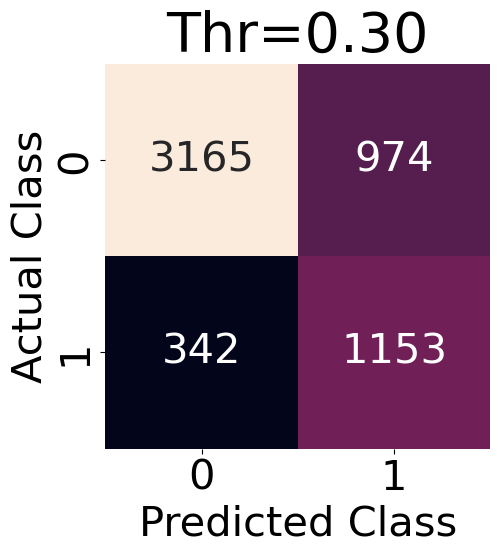

In [51]:
plot_confusion_matrix(y_train, lr_pred_train, 0.3)

In [20]:
return_recall_precision_f1(y_train, lr_pred_train, lr_optimal_threshold, lr_pipe_gs.refit_time_, 'lr scores')

,recall,precision,f1-score,roc-auc,fit-time
lr scores,0.773913,0.542429,0.637817,0.846077,0.068932


Random Forest

In [21]:
rf_pipe = Pipeline([
    ('Column_transformer', column_transformer),
    ('Over_Sampling', None),
    ('Under_Sampling', None),
    ('Random_forest', RandomForestClassifier(random_state=random_seed))
])

In [22]:
rf_pipe_params = [{
    
    # Sampling Params
    
    'Over_Sampling': [None, SMOTE(random_state=random_seed), ADASYN(random_state=34)],
    'Under_Sampling': [None, RandomUnderSampler(random_state=34)]
    
}]

In [23]:
rf_pipe_gs = GridSearchCV(rf_pipe, 
                          rf_pipe_params, 
                          cv=5, 
                          scoring=scoring,
                          return_train_score=False,
                          refit=model_refit,
                          n_jobs = -1)

rf_pipe_gs.fit(X_train, y_train);

In [24]:
rf_pipe_gs.best_score_ # 0.846
rf_pipe_gs.best_estimator_

0.8245605704708115

Pipeline(steps=[('Column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical_pipeline',
                                                  Pipeline(steps=[('One_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd32c49e4c0>)])),
                ('Over_Sampling', None), ('Under_Sampling', None),
                ('Random_forest', RandomForestClassifier(random_state=34))])

In [25]:
rf_pred_train = cross_val_predict(rf_pipe_gs.best_estimator_, 
                                  X_train, 
                                  y_train, 
                                  cv=5, 
                                  n_jobs = -1, 
                                  method="predict_proba")

In [26]:
rf_optimal_threshold = find_optimal_threshold(y_train, rf_pred_train)
rf_optimal_threshold

0.3

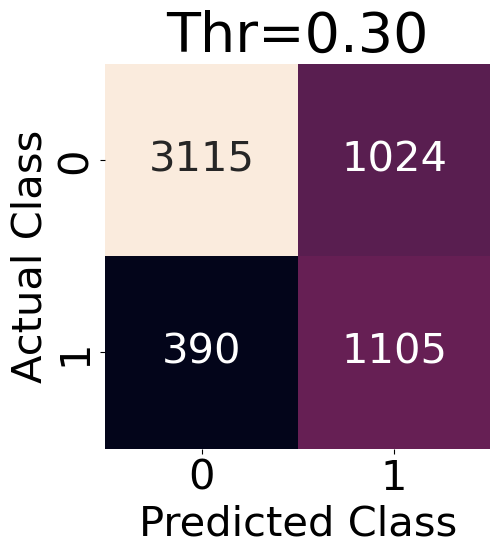

In [27]:
plot_confusion_matrix(y_train, rf_pred_train, rf_optimal_threshold)

In [28]:
return_recall_precision_f1(y_train, rf_pred_train, rf_optimal_threshold, rf_pipe_gs.refit_time_, 'rf scores')

,recall,precision,f1-score,roc-auc,fit-time
rf scores,0.73913,0.519023,0.609823,0.823902,0.471811


<center><h3>Model Selection

In [29]:
results_df = \
    pd.concat([return_recall_precision_f1(y_train, lr_pred_train, lr_optimal_threshold, 
                                          lr_pipe_gs.refit_time_, 'logistic regression'),
               return_recall_precision_f1(y_train, rf_pred_train, rf_optimal_threshold, 
                                          rf_pipe_gs.refit_time_, 'rf scores')])

results_df

,recall,precision,f1-score,roc-auc,fit-time
logistic regression,0.773913,0.542429,0.637817,0.846077,0.068932
rf scores,0.739130,0.519023,0.609823,0.823902,0.471811


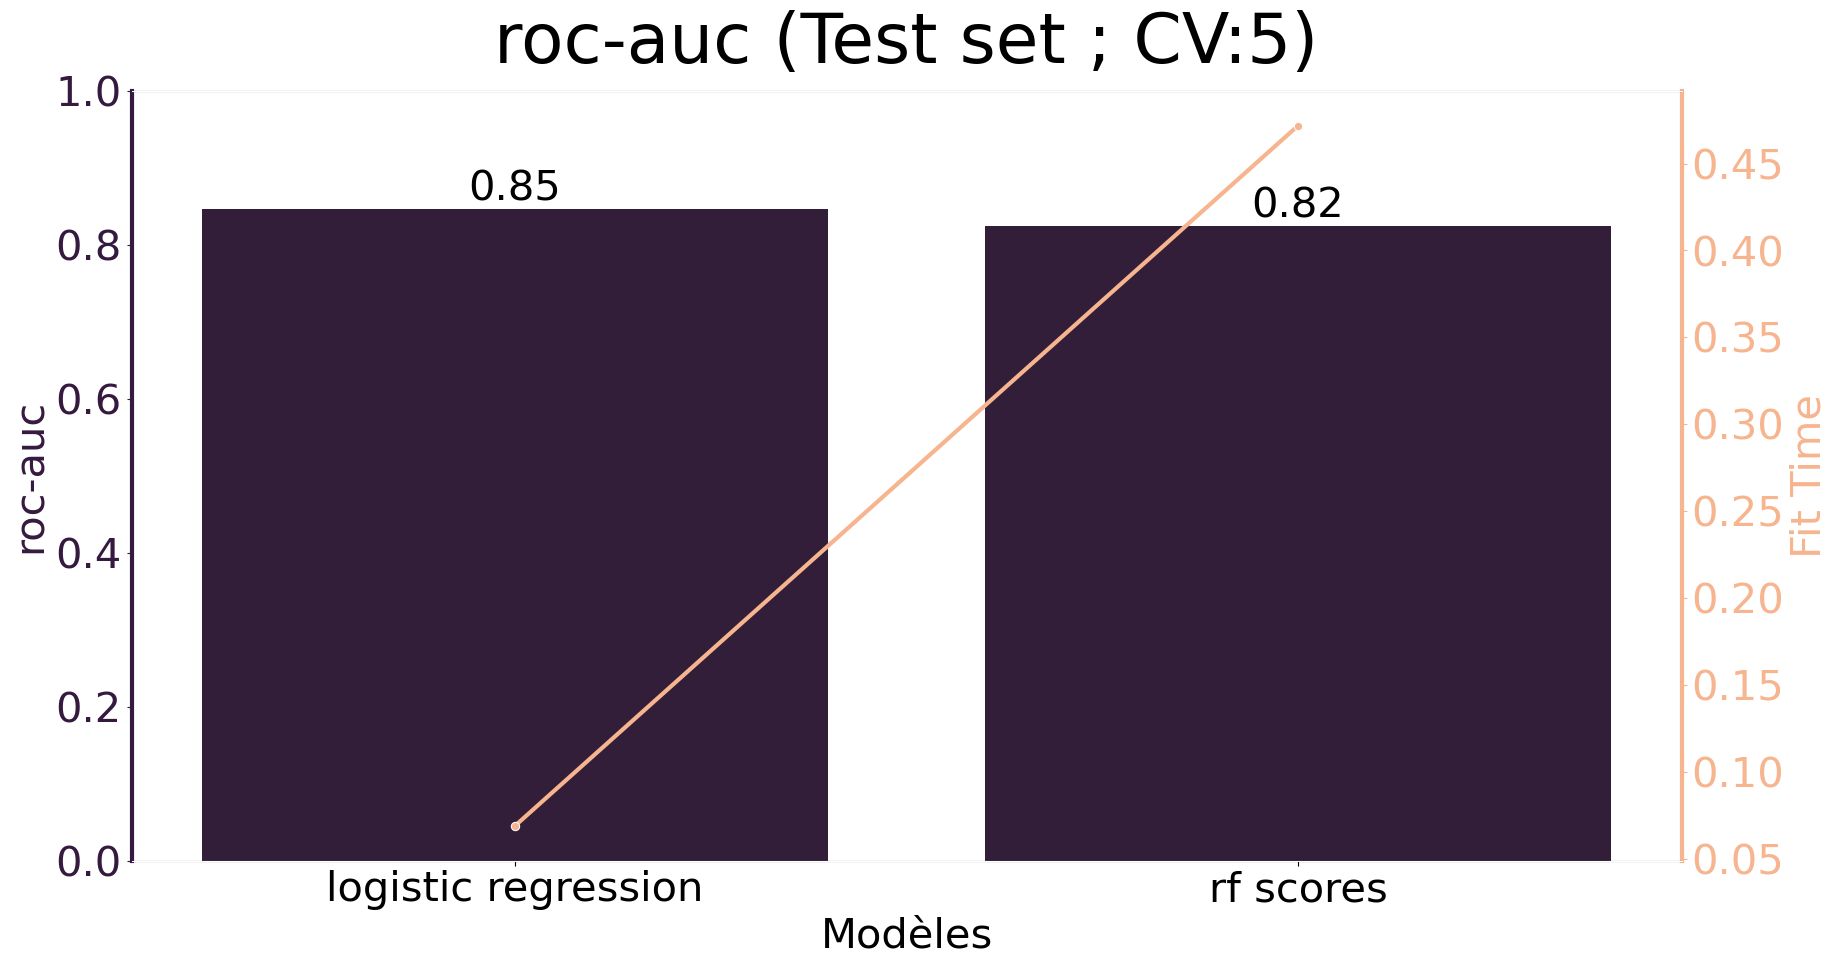

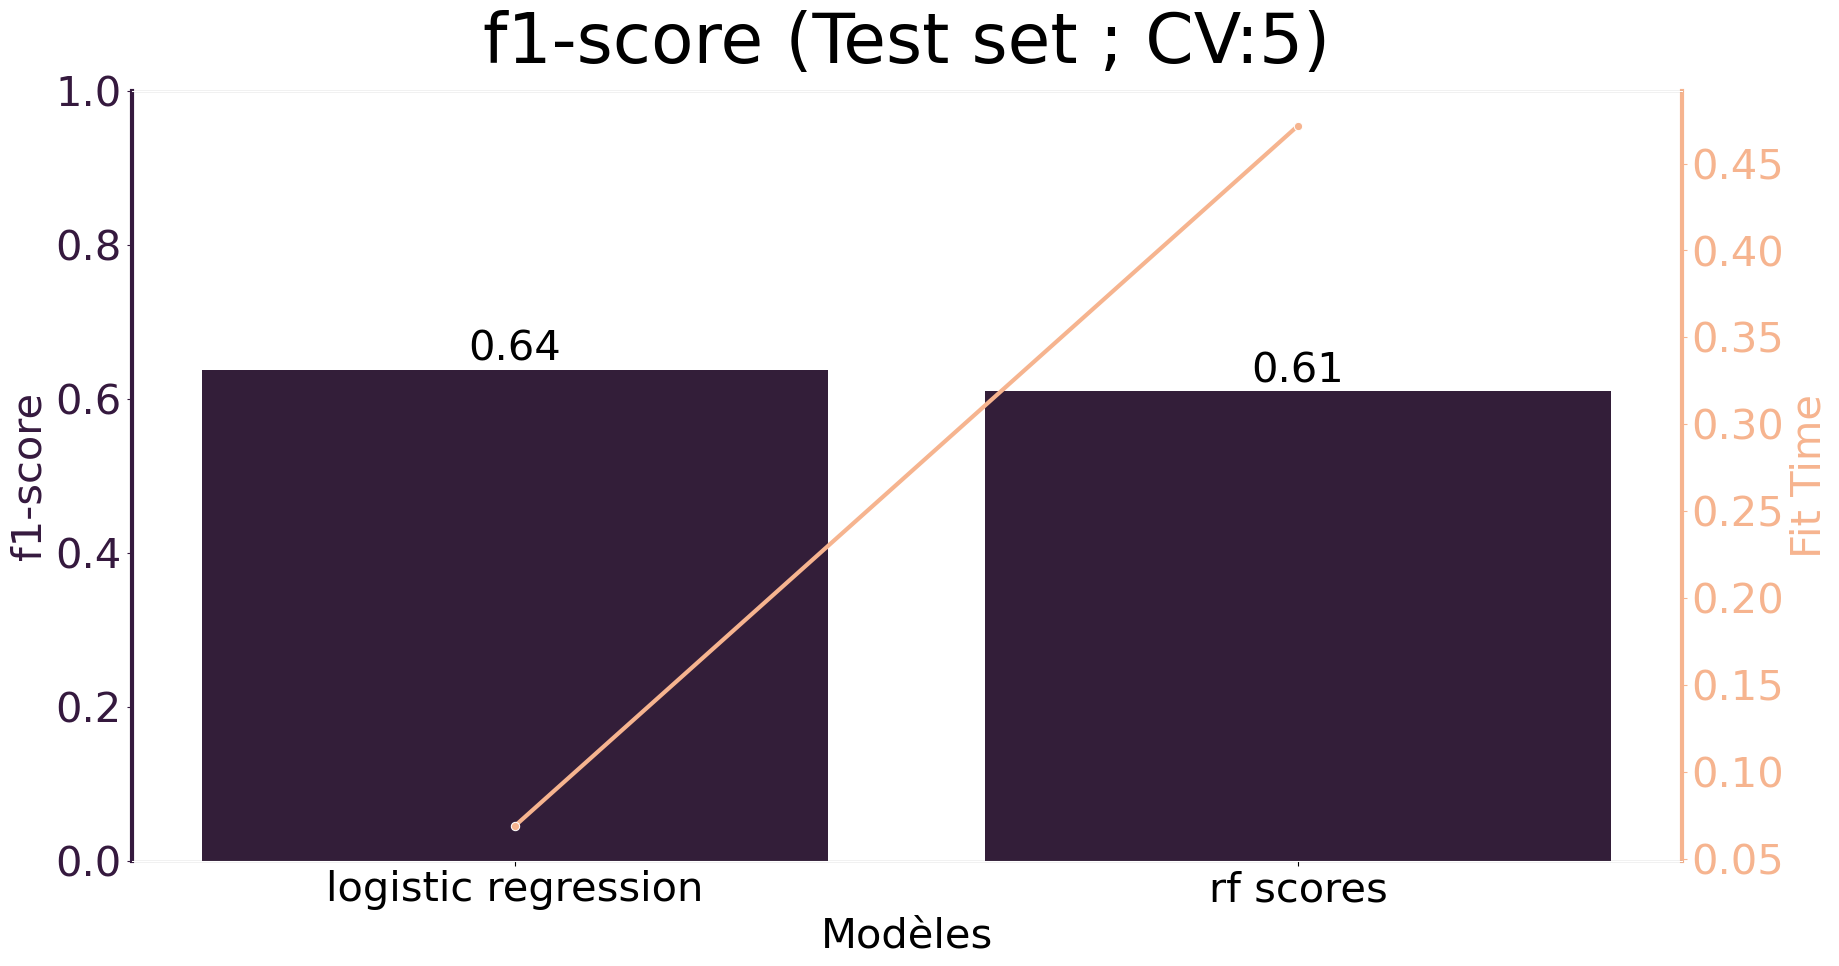

In [30]:
plot_compare_score('roc-auc')
plot_compare_score('f1-score')

<center><h3>Business Simulation

In [81]:
final_model = lr_pipe_gs.best_estimator_
final_model_threshold = lr_optimal_threshold

final_model

Pipeline(steps=[('Column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical_pipeline',
                                                  Pipeline(steps=[('One_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd32de4d370>)])),
                ('Over_Sampling', None), ('Under_Sampling', None),
                ('Scaler', StandardScaler()), ('Dim_Reduction', None),
                ('Logistic_regression',
                 LogisticRegression(max_iter=1000, random_state=34))])

Set up

In [139]:
# Ground truth figures

train_monthly_charges = X_train['MonthlyCharges'].reset_index()['MonthlyCharges'] 

train_yearly_charges = train_monthly_charges * 12  

train_yearly_charges_mean = train_yearly_charges.mean()

train_yearly_charges_median = train_yearly_charges.median()

train_yearly_charges_mean
train_yearly_charges_median

777.9294994675213

845.1000000000001

Median loss

In [140]:
train_total_loss_median_inference = (y_train * train_yearly_charges_median).sum()

train_total_loss_median_inference

1263424.5000000002

Predictions Loss

In [141]:
train_final_model_confusion_matrix = \
            confusion_matrix(y_train, (final_model.predict_proba(X_train)[:,1] >= final_model_threshold).astype(int))

train_final_model_confusion_matrix

array([[3181,  958],
       [ 336, 1159]])

In [162]:
n_not_predicted = train_final_model_confusion_matrix[1][0]
n_potentialy_retained = train_final_model_confusion_matrix[1][1]
n_subject_to_mkt_campaign = train_final_model_confusion_matrix[1][1] + train_final_model_confusion_matrix[0][1] 

print('Not predicted : {}'.format(n_not_predicted))
print('Potentialy Retained : {}'.format(n_potentialy_retained))
print('Submited to marketing campaign : {}'.format(n_subject_to_mkt_campaign))
print('Retained Ratio : [0, 1]')


campaign_mkt_price_for_one_user = 10

print('Marketing campaign price for one client = {} euros\n'.format(campaign_mkt_price_for_one_user))

print('Total Estimated Loss = n not predicted * statistical client loss + (1 - retained ratio) *\
 n potentialy retained * statistical client loss + n submited to marketing campaign * campaign price for one client')

Not predicted : 336
Potentialy Retained : 1159
Submited to marketing campaign : 2117
Retained Ratio : [0, 1]
Marketing campaign price for one client = 10 euros

Total Estimated Loss = n not predicted * statistical client loss + (1 - retained ratio) * n potentialy retained * statistical client loss + n submited to marketing campaign * campaign price for one client


Computation